#Necessary libraries

In [ ]:
!pip install selenium
!pip install pytesseract
!sudo apt install tesseract-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 27.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (14.8 MB/s)
debconf: unab

# Selenium webdriver in google colab

In [ ]:
from selenium import webdriver

def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

# Connect to IRCTC website and Login using Selenium

In [ ]:
def connect_to_irctc():
    """Logs in to the IRCTC website."""
    # Initialize the WebDriver
    driver = web_driver()
    driver.get('https://www.irctc.co.in/nget/train-search')
    driver.set_window_size(1920, 1080)

    print('connected to IRCTC Website: ', driver.title)
    return driver

driver = connect_to_irctc()

connected to IRCTC Website:  IRCTC Next Generation eTicketing System


trying to login......
filling username and password.....
Handling Captcha....
--- Run time of Connect to IRCTC website and Login: 7.007740259170532 seconds ---



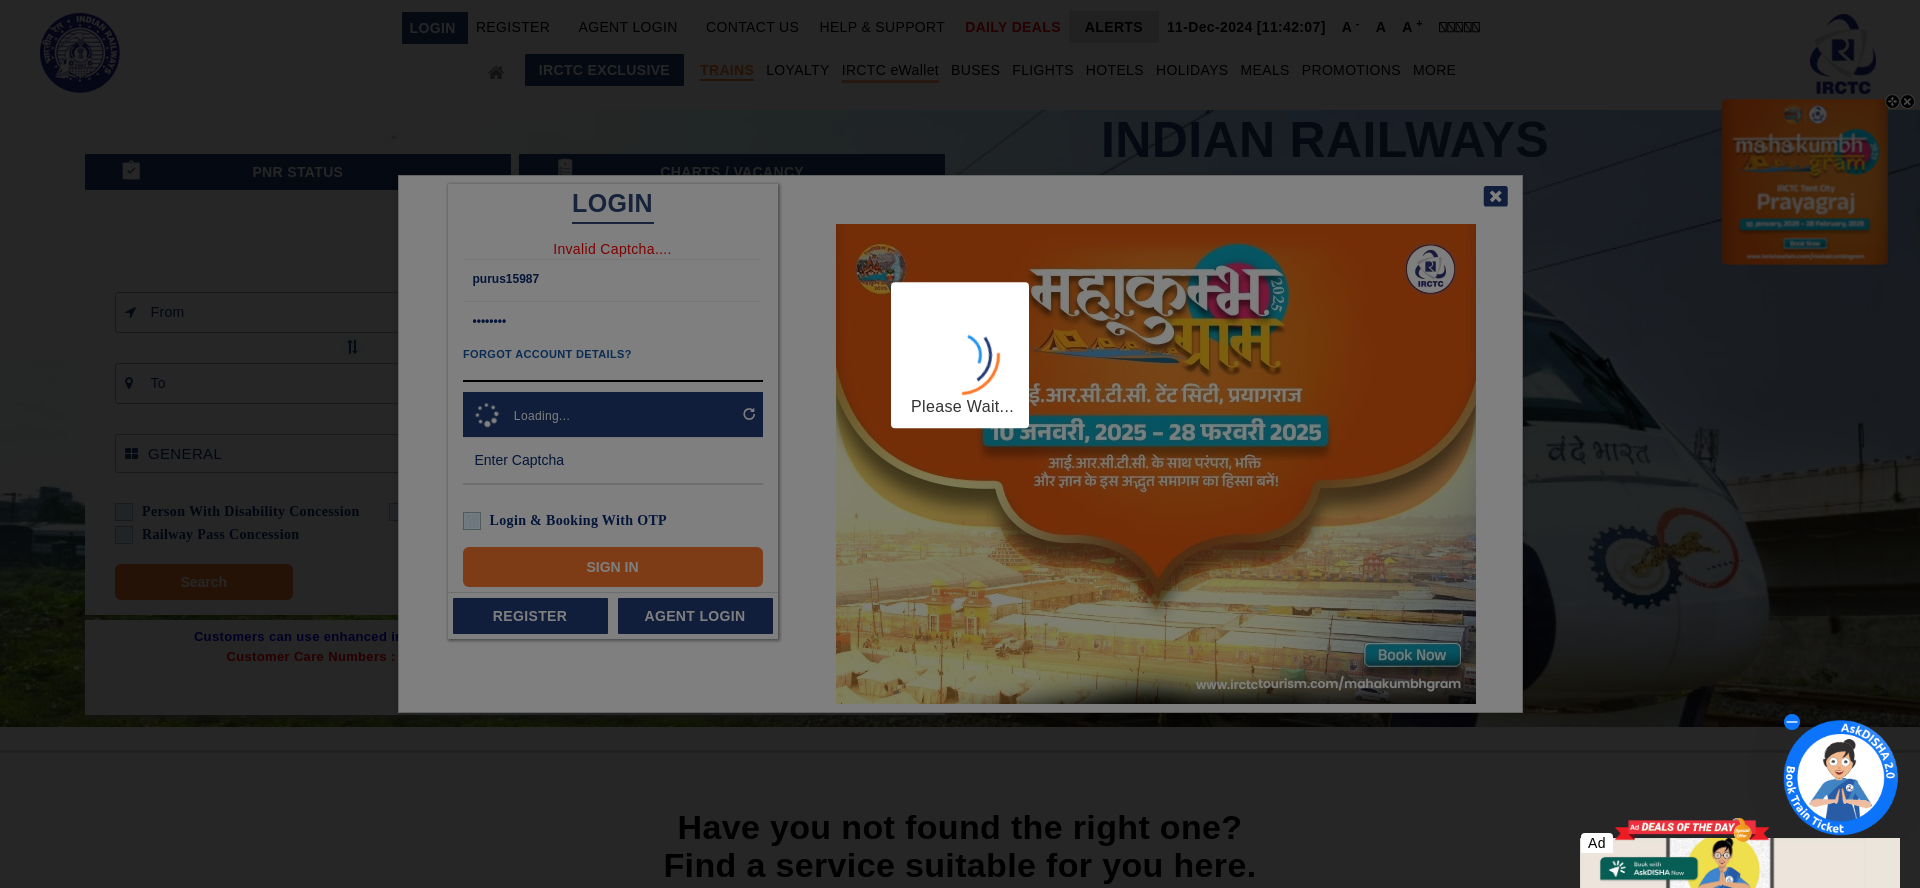

In [ ]:
# from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import time
import cv2
import numpy as np
import base64
import pytesseract
from google.colab.patches import cv2_imshow

# Configure Tesseract path
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

# Global variable
count = 0

def save_and_show_screenshot(driver):
    """Takes a screenshot of the current page and displays it."""
    global count
    count += 1
    screenshot_path = f'scraping_screenshot_{count}.png'
    driver.save_screenshot(screenshot_path)

    scraping_screenshot = cv2.imread(screenshot_path)
    cv2_imshow(scraping_screenshot)

def extract_captcha_from(base64_captcha):
    """Decodes and extracts the captcha image from its Base64 representation."""
    base64_captcha_image = base64_captcha.split(",")[1]
    image_data = base64.b64decode(base64_captcha_image)
    nparr = np.frombuffer(image_data, np.uint8)
    captcha_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return captcha_image

def extract_text_from_captcha(captcha_image):
    """Uses Tesseract to extract text from the captcha image."""
    extracted_text = pytesseract.image_to_string(captcha_image, config='--oem 3 --psm 6', lang="eng")
    # Clean up extracted text
    text = ''.join(char if char.isprintable() else '' for char in extracted_text)
    text = text.replace(" ", "")
    return text


def handling_captcha(driver):
    print('Handling Captcha....')
    captcha_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//img[@class="captcha-img"]'))
    )
    base64_captcha = captcha_element.get_attribute('src')
    captcha_image = extract_captcha_from(base64_captcha)
    extracted_text = extract_text_from_captcha(captcha_image)

    # Enter captcha text
    captcha_input_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//input[@id="captcha"]'))
    )
    captcha_input_element.send_keys(extracted_text)
    captcha_input_element.send_keys(Keys.ENTER)

    try:
        captcha_error_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, '//div[@class="loginError"]'))
        )
        if(captcha_error_element.text == 'Invalid Captcha....'):
            print('captcha miss match,  Retrying to login......')
            time.sleep(4)
            refresh_captcha_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, '//a[@class="pull-right"]'))
            )
            refresh_captcha_element.click()
            handling_captcha(driver)
    except TimeoutException:
        print("no Captcha error.....")

    return driver


def login_to_irctc(driver, username, password):
    print('trying to login......')

    # Click on login button
    login_element = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//a[@class="search_btn loginText ng-star-inserted"]'))
    )
    login_element.click()

    # Enter username and password
    print('filling username and password.....')
    username_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//input[@class="form-control input-box ng-pristine ng-valid ng-touched"]'))
    )
    password_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//input[@class="form-control input-box ng-untouched ng-pristine ng-valid"]'))
    )

    username_element.send_keys(username)
    password_element.send_keys(password)

    driver = handling_captcha(driver)
    # Return the driver for further interaction
    return driver

# Example usage
username = 'purus15987'
password = '*********'


start_time = time.time()
driver = login_to_irctc(driver, username, password)
print("--- Run time of Connect to IRCTC website and Login: %s seconds ---\n" % (time.time() - start_time))

time.sleep(5)
save_and_show_screenshot(driver)

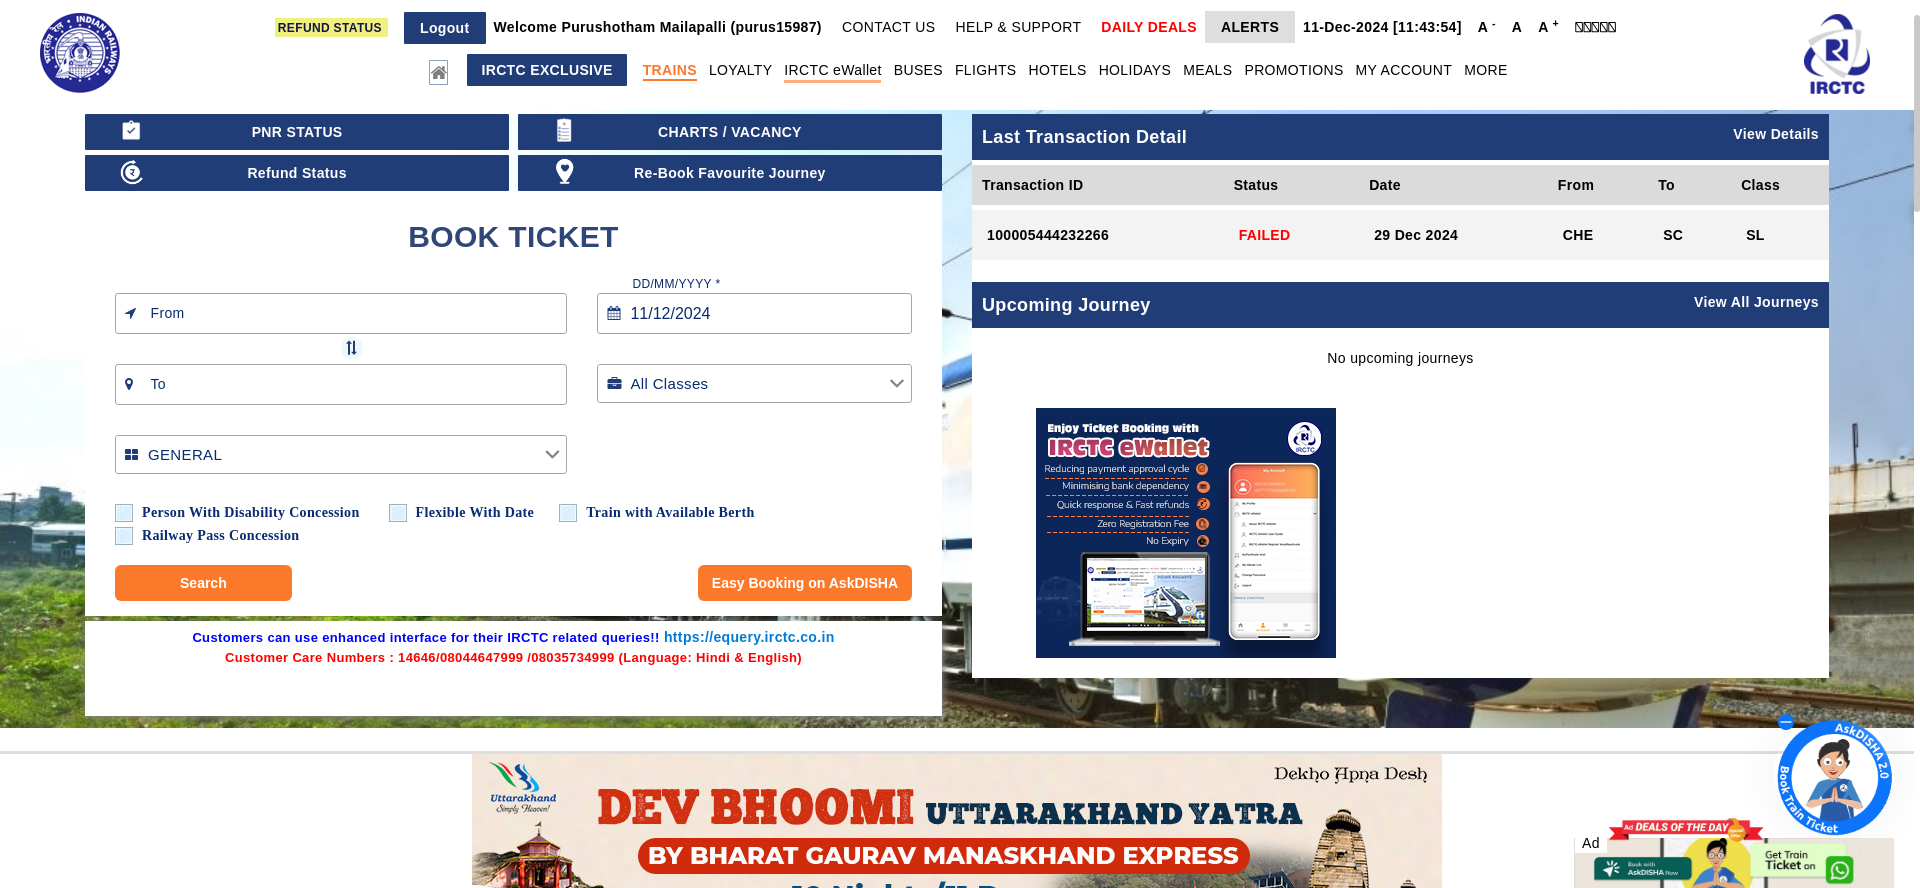

In [ ]:
save_and_show_screenshot(driver)

# Filling Train Details

filling from and to destinations.....
filling Train class.....
selecting Date.....
submiting the train details.....
--- Runtime of Filling Train-details: 14.796862125396729 seconds ---



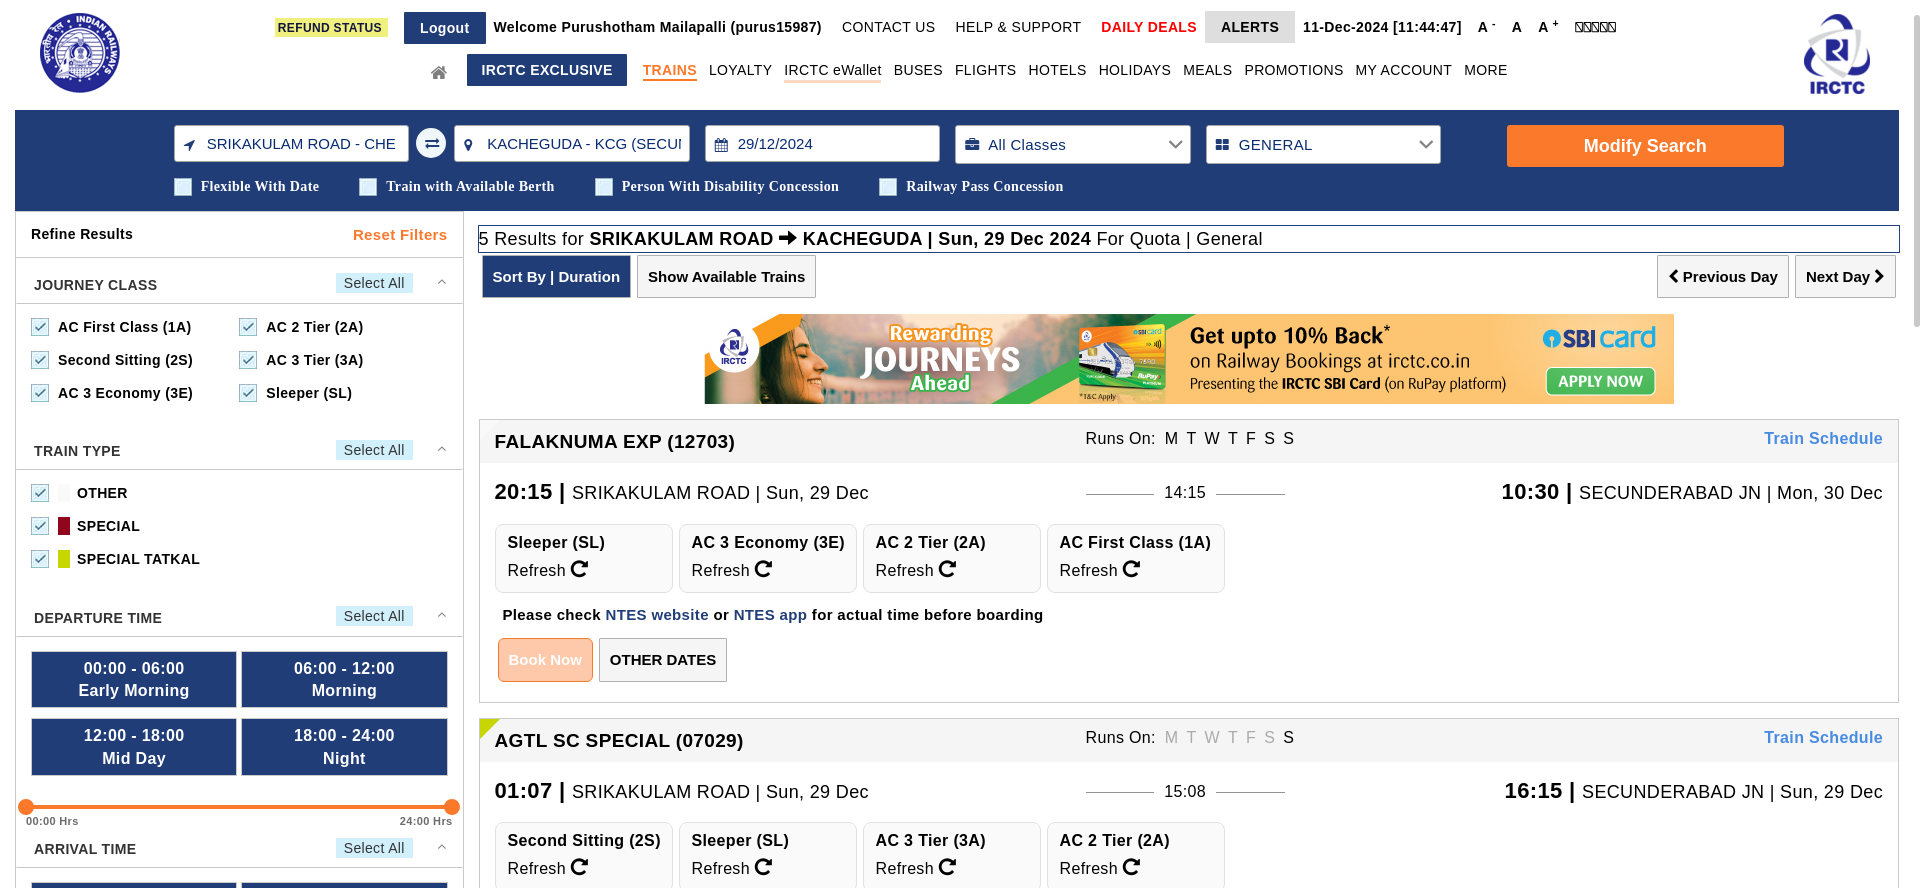

In [ ]:
def train_details(driver, from_station, to_station, travel_date, travel_class="GENERAL"):
    """Fills in train details on the IRCTC website."""

    # Select from and to destinations
    print('filling from and to destinations.....')
    from_destination_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//input[@class="ng-tns-c57-8 ui-inputtext ui-widget ui-state-default ui-corner-all ui-autocomplete-input ng-star-inserted"]'))
    )
    to_destination_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//input[@class="ng-tns-c57-9 ui-inputtext ui-widget ui-state-default ui-corner-all ui-autocomplete-input ng-star-inserted"]'))
    )

    from_destination_element.clear()
    from_destination_element.send_keys(from_station)
    time.sleep(2)
    from_destination_element.send_keys(Keys.ARROW_DOWN)
    from_destination_element.send_keys(Keys.ENTER)

    to_destination_element.clear()
    to_destination_element.send_keys(to_station)
    time.sleep(2)
    to_destination_element.send_keys(Keys.ARROW_DOWN)
    to_destination_element.send_keys(Keys.ENTER)
    # Select class
    print('filling Train class.....')
    select_class_element = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//div[@class="ng-tns-c65-12 ui-dropdown ui-widget ui-state-default ui-corner-all"]'))
    )
    select_class_element.click()

    if travel_class.upper() == "TATKAL":
        time.sleep(1)
        tatkal_class_element = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "li[role='option'][aria-label='TATKAL']"))
        )
        tatkal_class_element.click()
    else:
        time.sleep(1)
        general_class_element = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "li[role='option'][aria-label='GENERAL']"))
        )
        general_class_element.click()

    # Select date
    print('selecting Date.....')
    select_date_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//input[@class="ng-tns-c58-10 ui-inputtext ui-widget ui-state-default ui-corner-all ng-star-inserted"]'))
    )
    select_date_element.send_keys('a')  # Workaround for clearing date
    select_date_element.clear()
    select_date_element.send_keys(travel_date)

    # Search train details
    print('submiting the train details.....')
    search_element = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//button[@type="submit" and @label="Find Trains" and @class="search_btn train_Search"]'))
    )
    search_element.click()

    time.sleep(5)  # Wait for train details to load
    return driver


from_station = 'SRIKAKULAM'
to_station = 'SECUNDERABAD'
travel_date = '29/12/2024'
travel_class = 'GENERAL'

start_time = time.time()
driver = train_details(driver, from_station, to_station, travel_date, travel_class)
print("--- Runtime of Filling Train-details: %s seconds ---\n" % (time.time() - start_time))

save_and_show_screenshot(driver)

#Confirm Train no. and coach

Found required train.......
Sleeper (SL)
Refresh
Found your SL coach.......
Searching date details......
Booking searching......
Confirming as destinations are mismatched....
--- Runtime of Filling Train-details: 15.169175863265991 seconds ---



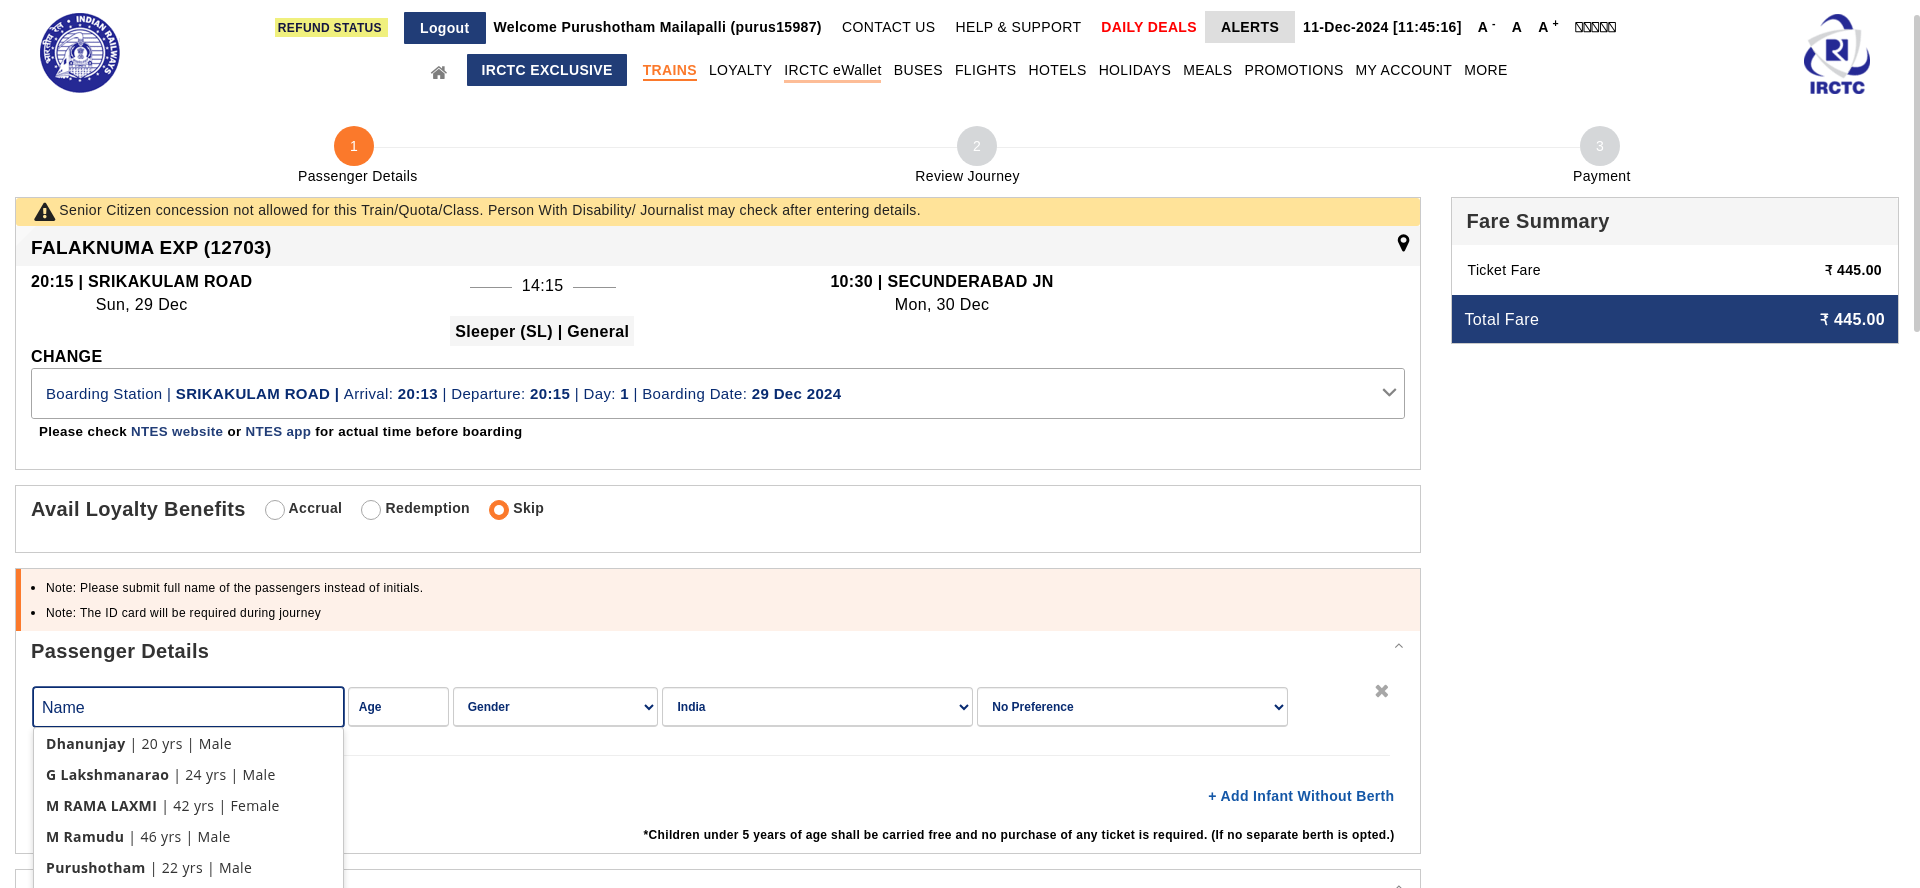

In [ ]:
def confirm_train_and_coach(driver, train_number, coach_preference):
    """Confirms the train and coach details."""
    trains_element = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CLASS_NAME, 'train-heading'))
    )

    for train in trains_element:
        if train_number in train.text:
            print('Found required train.......')
            required_train_element = train.find_element(By.XPATH, './../..')  # Use './../..' to move to the parent
            coach_elements = required_train_element.find_elements(By.CLASS_NAME, 'pre-avl')
            for coach in coach_elements:
                print(coach.text)
                if coach_preference in coach.text:
                    print(f'Found your {coach_preference} coach.......')
                    coach.click()
                    time.sleep(3)

                    print('Searching date details......')
                    date_element = required_train_element.find_element(By.CLASS_NAME, 'pre-avl')
                    date_element.click()
                    time.sleep(3)

                    print('Booking searching......')
                    book_now_element = driver.find_element(By.XPATH, '//button[@class="btnDefault train_Search ng-star-inserted"]')
                    book_now_element.click()
                    time.sleep(5)

                    confirm_element = WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.XPATH, '//*[@id="divMain"]/div/app-train-list/p-confirmdialog[2]/div/div/div[3]/button[1]'))
                    )
                    if confirm_element:
                        print('Confirming as destinations are mismatched....')
                        confirm_element.click()
                        time.sleep(3)

                    return driver
                print('----')
            break
        print('------')


train_number = '12703'
coach_preference = 'SL'       # coaches = ['SL','2S','3A','2A']

start_time = time.time()
driver = confirm_train_and_coach(driver, train_number, coach_preference)
print("--- Runtime of Filling Train-details: %s seconds ---\n" % (time.time() - start_time))

save_and_show_screenshot(driver)

#Fill Passenger Details

--- Runtime of Filling Passenger-details: 11.118337869644165 seconds ---



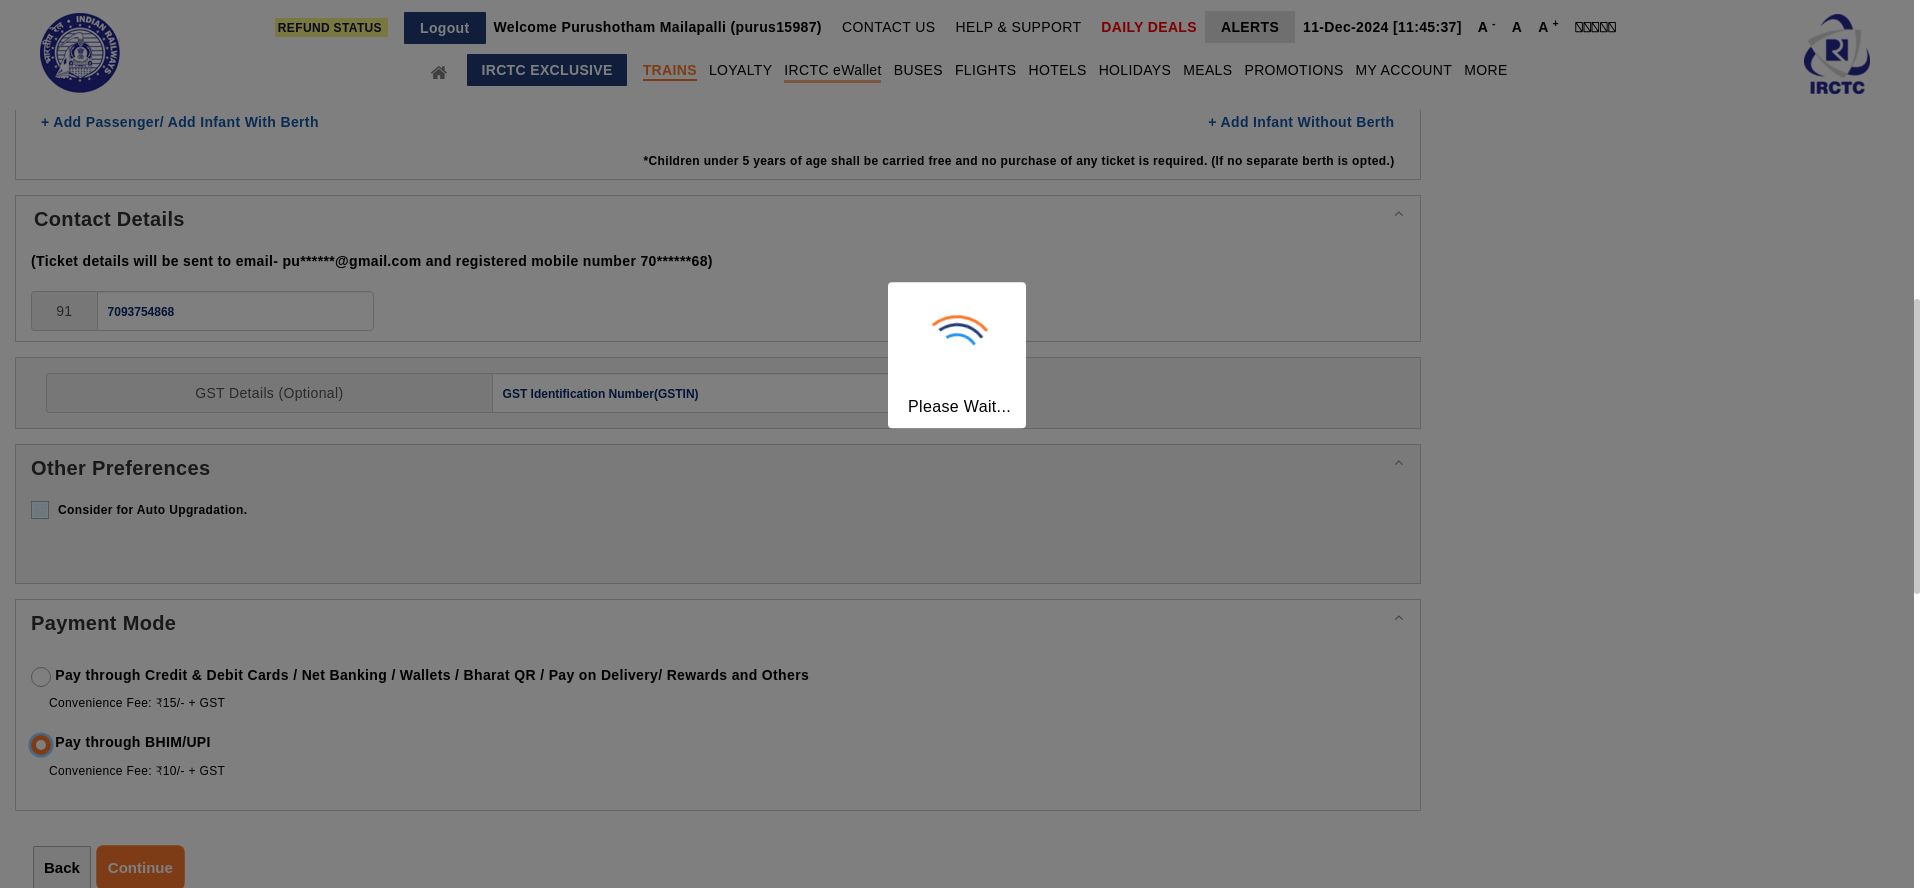

In [ ]:
def fill_passenger_details(driver, details, mobile_number, payment_mode):
    """Fills in passenger details, contact information, and selects payment mode."""
    for index, passenger_details in enumerate(details):
        passenger_id = index + 1
        passenger_name_XPATH = f'//*[@id="ui-panel-13-content"]/div/div[{passenger_id}]/div[2]/div/app-passenger/div/div[1]/span/div[1]/p-autocomplete/span/input'
        passenger_name_element = driver.find_element(By.XPATH, passenger_name_XPATH)
        passenger_name_element.send_keys(passenger_details['name'])

        passenger_age_XPATH = f'//*[@id="ui-panel-13-content"]/div/div[{passenger_id}]/div[2]/div/app-passenger/div/div[1]/span/div[2]/input'
        age_element = driver.find_element(By.XPATH, passenger_age_XPATH)
        age_element.clear()
        age_element.send_keys(passenger_details['age'])

        gender_XPATH = f'//*[@id="ui-panel-13-content"]/div/div[{passenger_id}]/div[2]/div/app-passenger/div/div[1]/span/div[3]/select/'

        if passenger_details['gender'] == 'male':
            gender_XPATH = gender_XPATH + 'option[2]'
        elif passenger_details['gender'] == 'female':
            gender_XPATH = gender_XPATH + 'option[3]'
        else:  # transgender
            gender_XPATH = gender_XPATH + 'option[4]'

        gender_element = driver.find_element(By.XPATH, gender_XPATH)
        gender_element.click()

        if len(details) != passenger_id:
            Add_passenger_XPATH = f'//*[@id="ui-panel-13-content"]/div/div[{passenger_id + 1}]/div[1]/a'
            Add_passenger_element = driver.find_element(By.XPATH, Add_passenger_XPATH)
            Add_passenger_element.click()
            time.sleep(3)

    # Enter mobile number
    mobile_number_element = driver.find_element(By.XPATH, '//*[@id="mobileNumber"]')
    mobile_number_element.send_keys(mobile_number)

    # Select payment mode
    if payment_mode == 'BHIM/UPI':
        payment_mode_element = driver.find_element(By.XPATH, '//*[@id="2"]')
        payment_mode_element.click()
    else:
        payment_mode_element = driver.find_element(By.XPATH, '//*[@id="3"]')
        payment_mode_element.click()

    # Continue to payment
    continue_element = driver.find_element(By.XPATH, '//*[@id="psgn-form"]/form/div/div[1]/div[16]/div/button[2]')
    continue_element.click()

    return driver



details = [
    {'name': 'M Purushotham', 'age': 24, 'gender': 'male'},
    {'name': 'M Pushpa', 'age': 19, 'gender': 'female'},
    {'name': 'M Ramudu', 'age': 45, 'gender': 'male'}
]
mobile_number = '8074468134'
payment_mode = 'BHIM/UPI'


start_time = time.time()
driver = fill_passenger_details(driver, details, mobile_number, payment_mode)
print("--- Runtime of Filling Passenger-details: %s seconds ---\n" % (time.time() - start_time))

save_and_show_screenshot(driver)

# Review Journey and Confirm Captcha

captcha - //*[@id="captcha-img"]

captcha_input - //*[@id="captcha"]

continue - captcha_input.ENTER


Handling Captcha....
no Captcha error.....


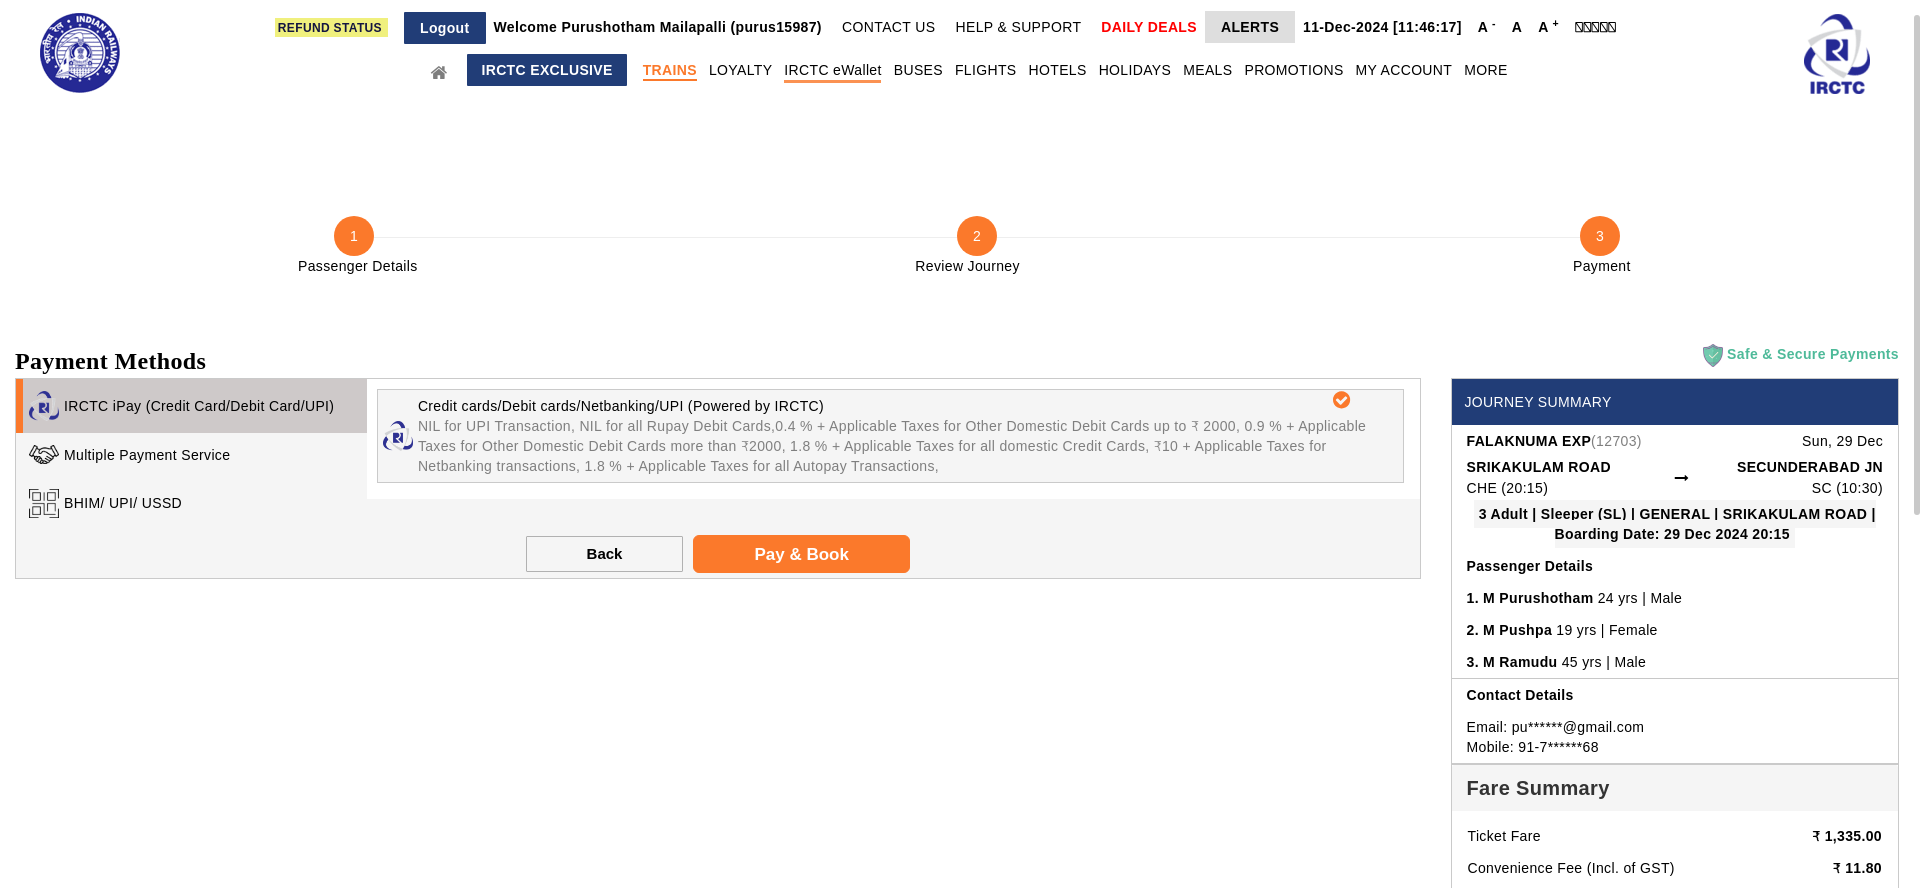

In [ ]:
driver = handling_captcha(driver)

time.sleep(5)
save_and_show_screenshot(driver)

# Proceed to Pay

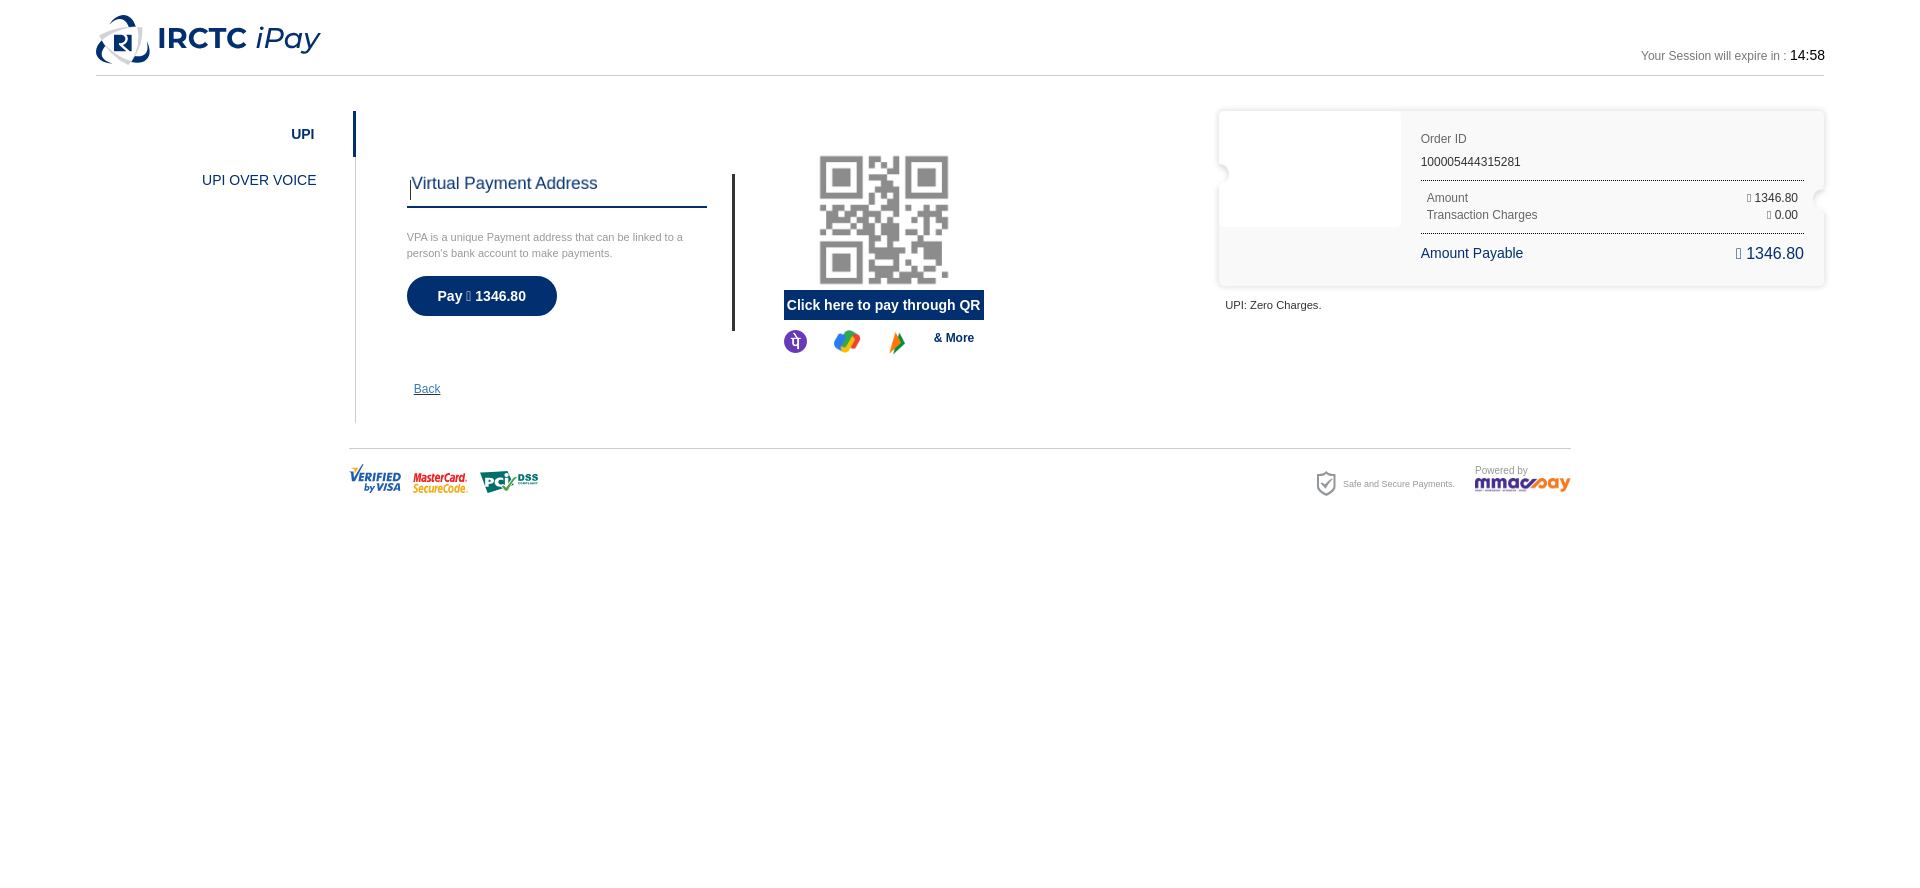

In [ ]:
payBook_element = driver.find_element(By.XPATH, '//*[@id="psgn-form"]/div[1]/div[1]/app-payment/div[2]/button[2]')
payBook_element.click()

time.sleep(5)
save_and_show_screenshot(driver)

//*[@id="vpaCheck"]

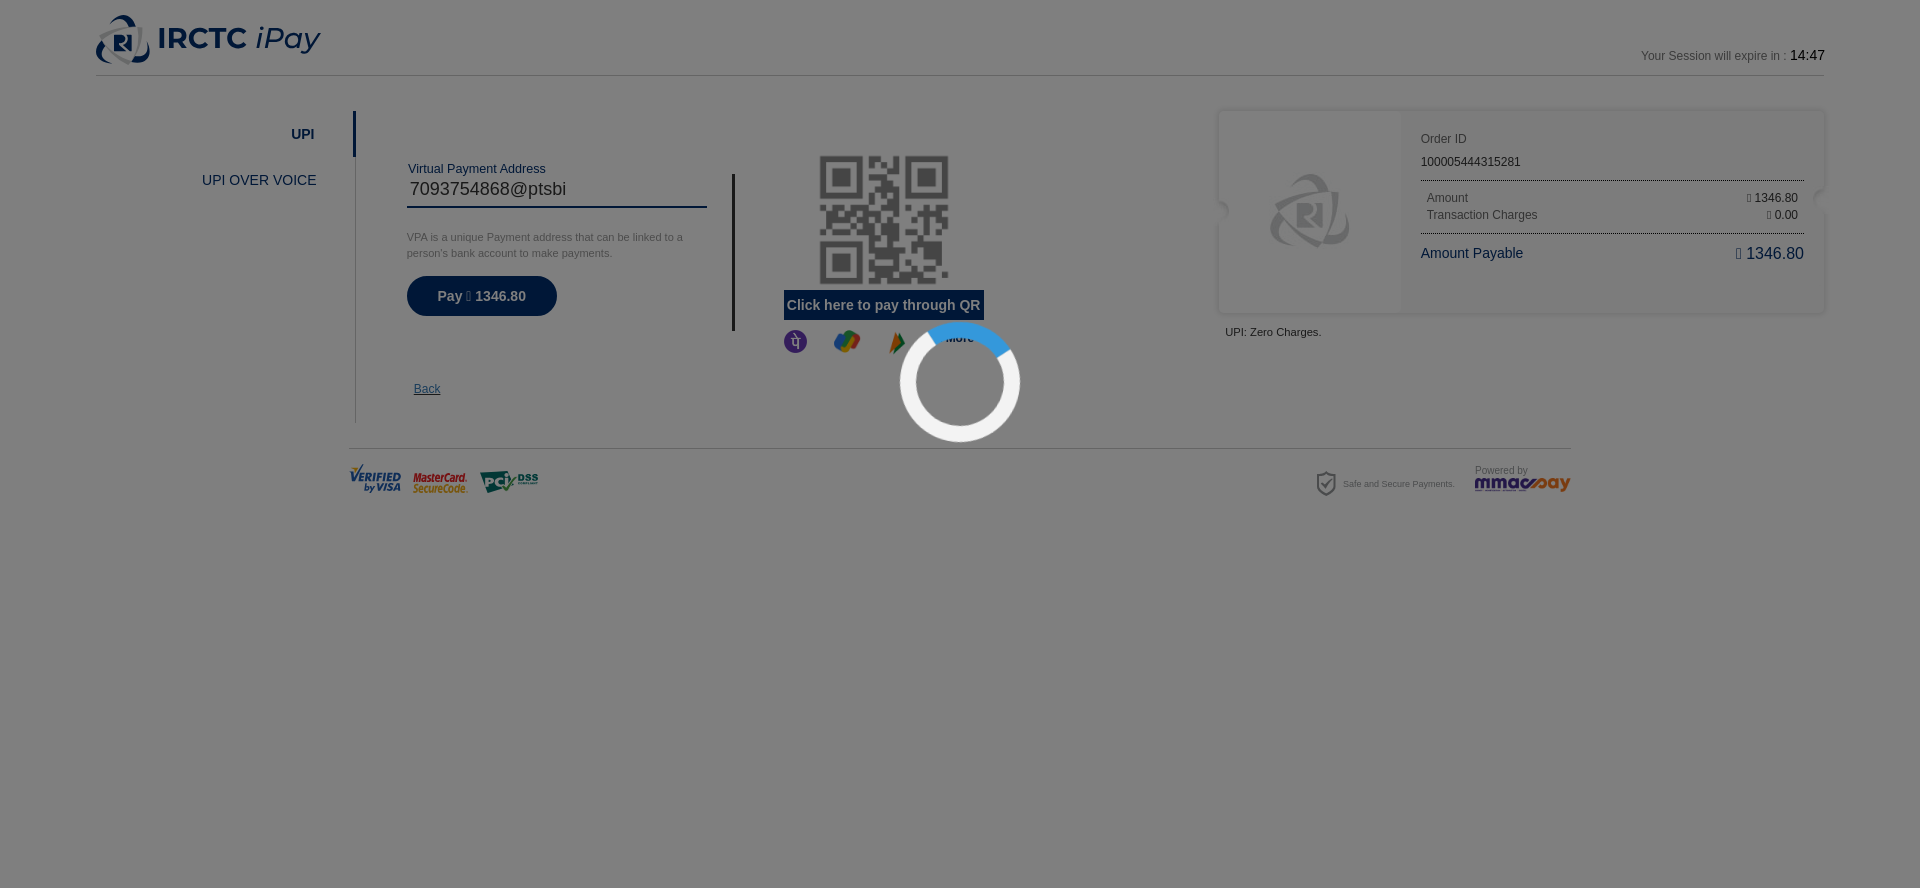

In [ ]:
MyUpiVpaId = '7093754868@ptsbi'
payByVPACheck_element = driver.find_element(By.XPATH,'//*[@id="vpaCheck"]')
payByVPACheck_element.send_keys(MyUpiVpaId)

submit_pay_element = driver.find_element(By.XPATH,'//*[@id="upi-sbmt"]')
submit_pay_element.click()

save_and_show_screenshot(driver)

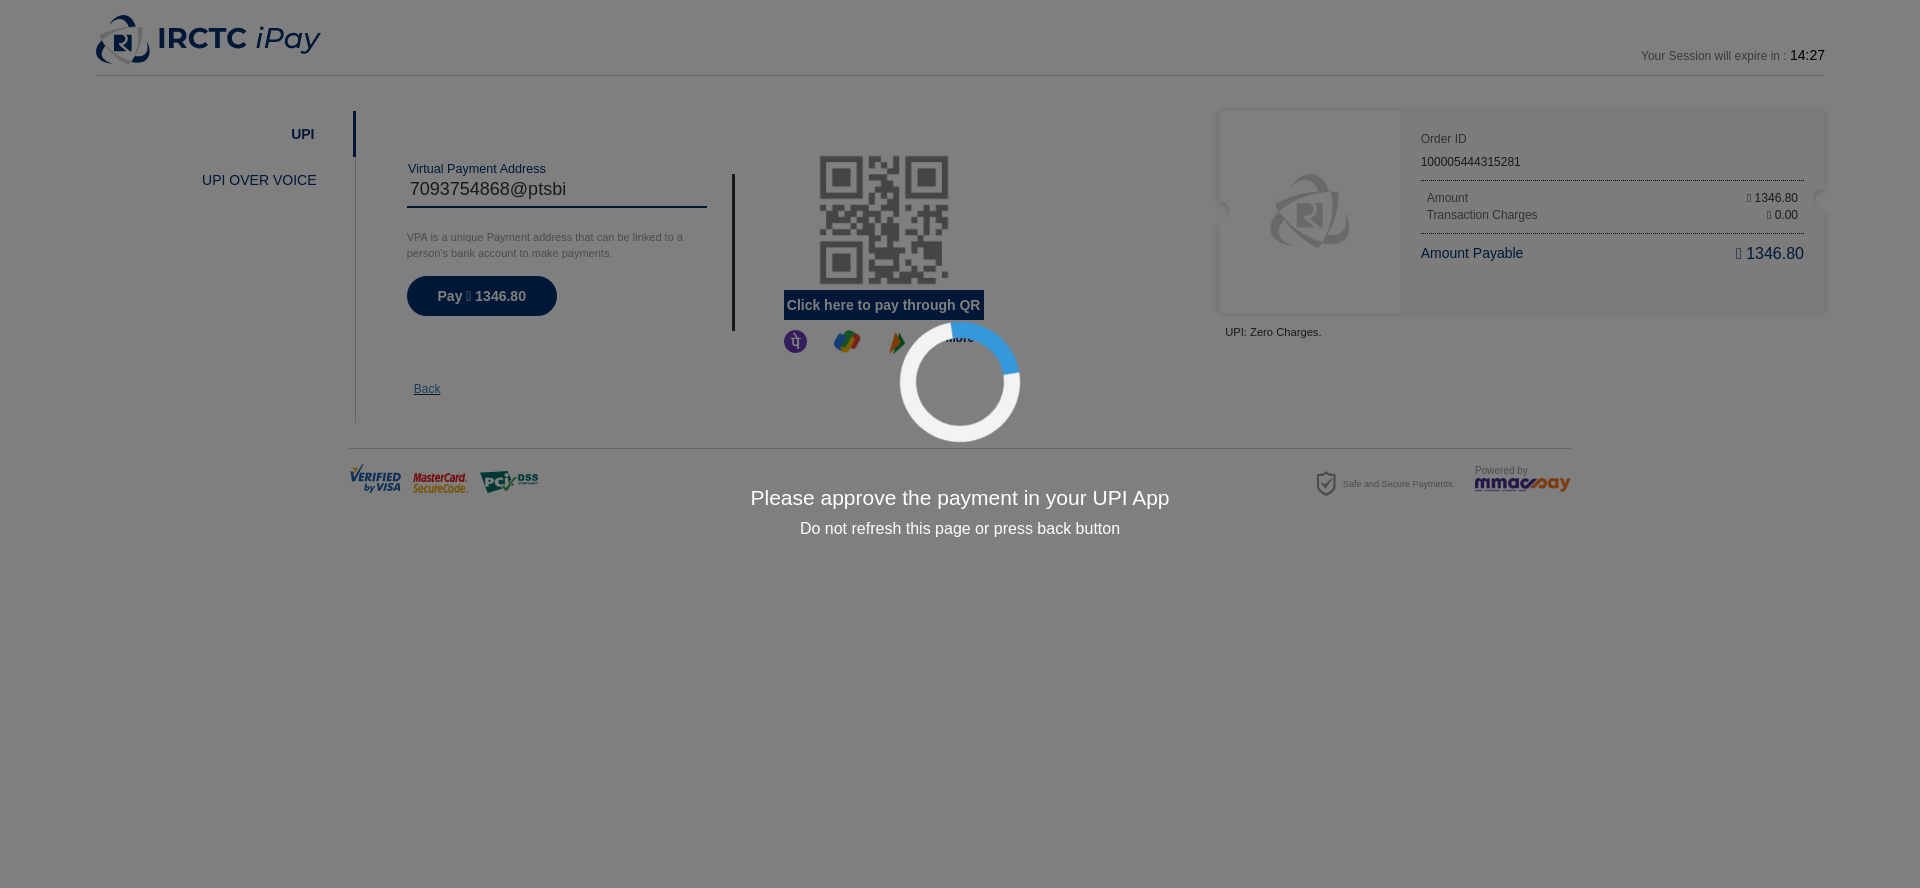

In [ ]:
save_and_show_screenshot(driver)

//*[@id="PayByQrButton"]

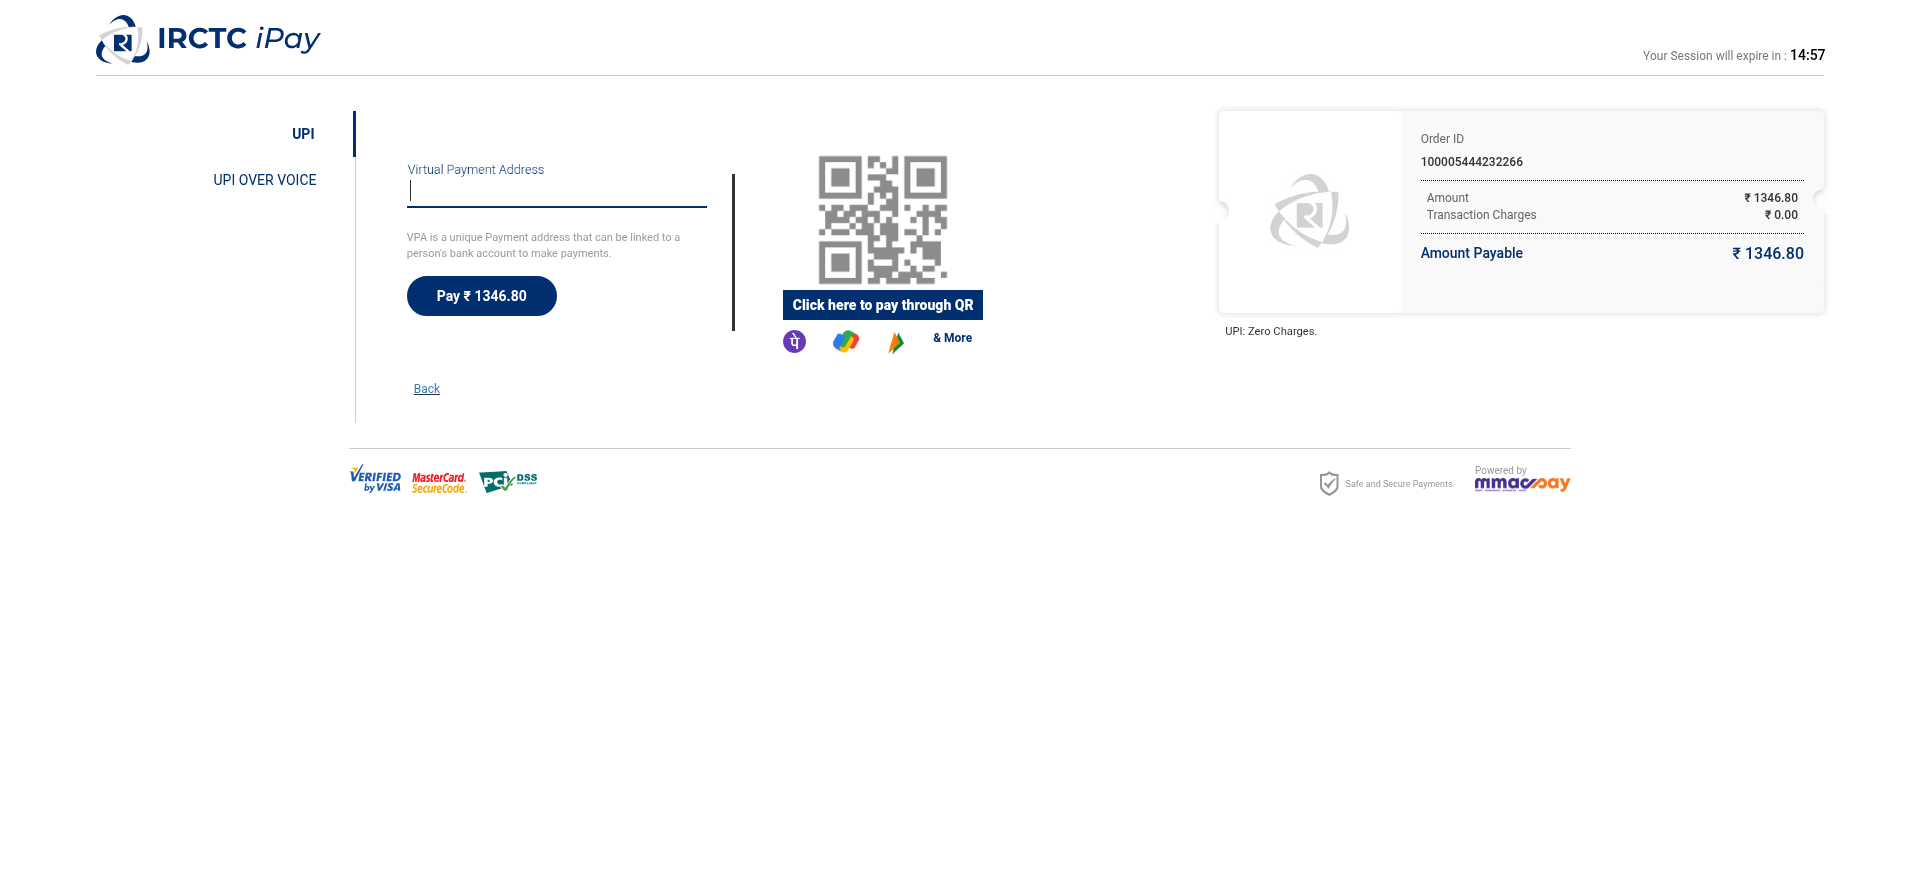

In [ ]:
payBook_element = driver.find_element(By.XPATH, '//*[@id="psgn-form"]/div[1]/div[1]/app-payment/div[2]/button[2]')
payBook_element.click()

time.sleep(5)
save_and_show_screenshot(driver)

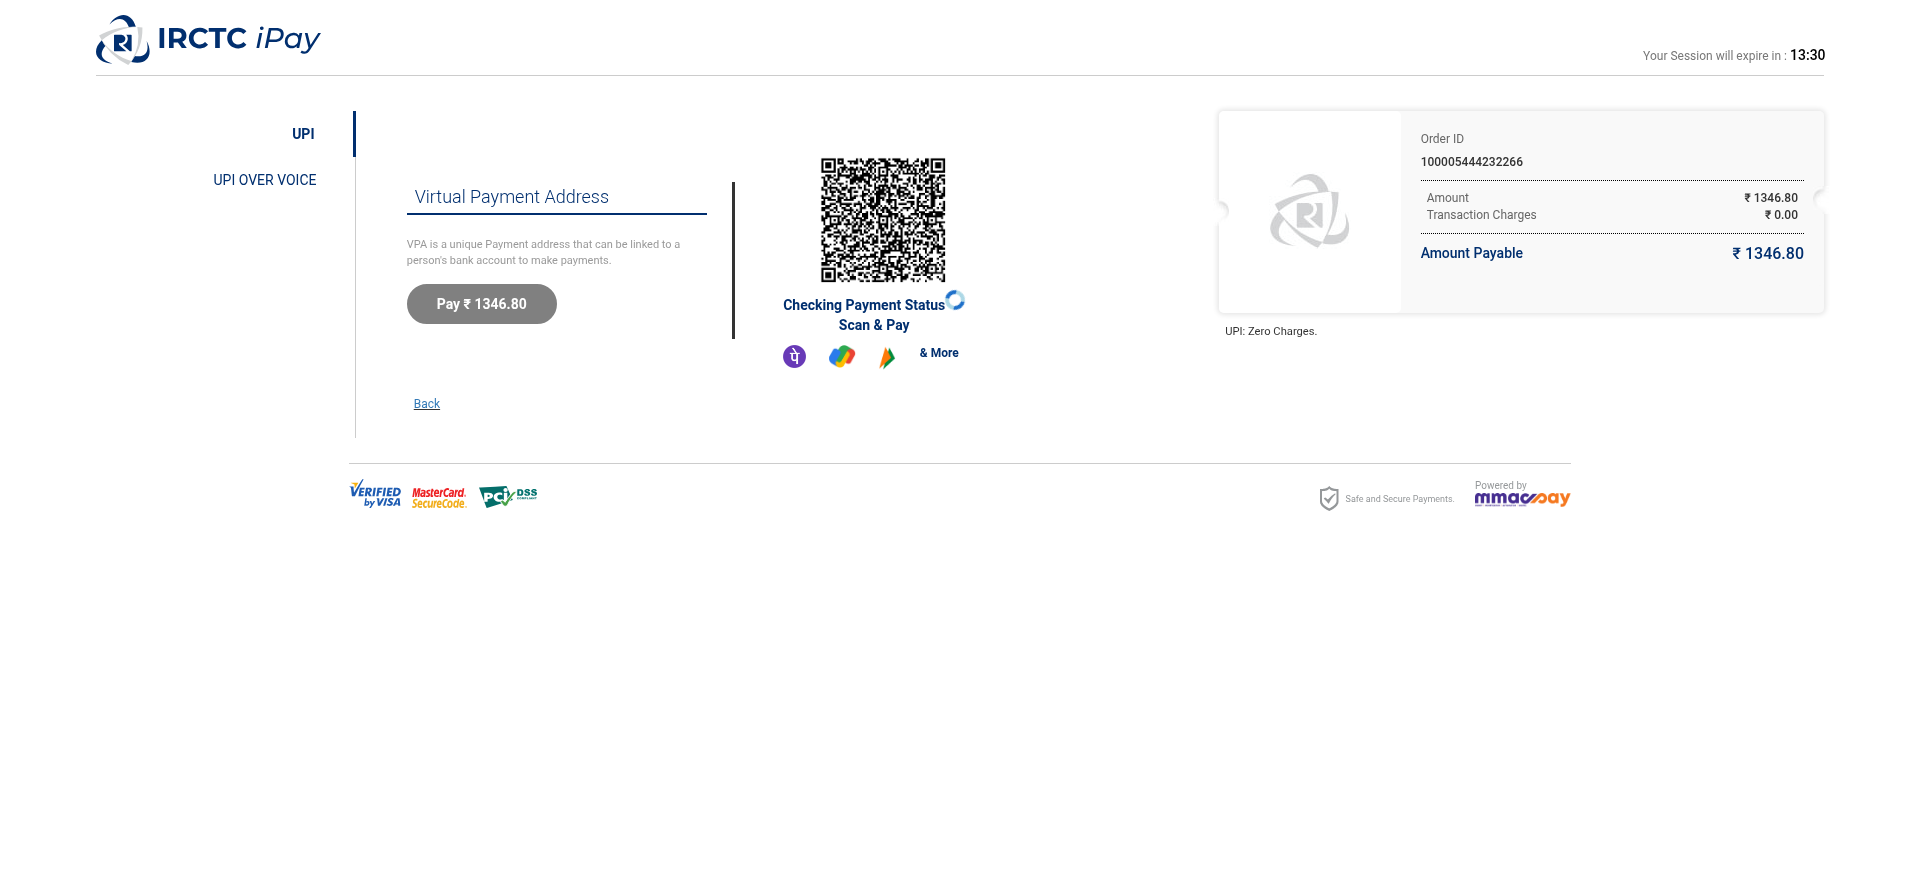

In [ ]:
save_and_show_screenshot(driver)

# IRCTC LOADER / LOADING

//*[@id="loaderP"]